In [36]:
import re
from datetime import datetime
import itertools
import random
from tqdm.auto import tqdm

import numpy as np
import polars as pl
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold
import japanize_matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
from sudachipy import tokenizer
from sudachipy import dictionary

from gensim.models import word2vec
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer

import wandb

from itertools import combinations
from scipy.cluster.hierarchy import DisjointSet
import Levenshtein

In [37]:
class Config:
    exp_name = "e013_add_title_feature"

In [38]:
train = pl.read_csv("../data/train.csv")
anime = pl.read_csv("../data/anime.csv")
test = pl.read_csv("../data/test.csv")
sample_submission = pl.read_csv("../data/sample_submission.csv")

# WandB

In [39]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [40]:
wandb.init(
    project="atmacup15",
    name=Config.exp_name
)

# animeに対する前処理

In [41]:
anime = anime.with_columns(
    pl.col("genres").str.split(",").apply(lambda x: len(x)).alias("genre_len"),
    pl.col("producers").str.split(",").apply(lambda x: len(x)).alias("producers_len"),
    pl.col("licensors").str.split(",").apply(lambda x: len(x)).alias("licensors_len"),
    pl.col("studios").str.split(",").apply(lambda x: len(x)).alias("studios_len"),
)

genre_len_col = ["genre_len","producers_len","licensors_len", "studios_len"]

In [42]:
anime = anime.with_columns(
    pl.when(pl.col("rating") == "Rx - Hentai")
    .then(20)
    .when(pl.col("rating") == "G - All Ages")
    .then(0)
    .when(pl.col("rating") == "R - 17+ (violence & profanity)")
    .then(17)
    .when(pl.col("rating") == "PG-13 - Teens 13 or older")
    .then(13)
    .when(pl.col("rating") == "PG - Children")
    .then(10)
    .otherwise(None)
    .alias("rating_num")
)

rating_num_col = ["rating_num"]

### episodes

In [43]:
anime = anime.with_columns(
    pl.when(pl.col("episodes") == "Unknown")
    .then(None)
    .otherwise(pl.col("episodes"))
    .cast(pl.Int64)
    .alias("episodes")
)

### duration

In [44]:
def extract_duration_time(text: str) -> int | None:
    if match := re.match(r"([0-9]{1,2}) min.", text):
        return int(match.group(1))
    elif match := re.match(r"([1-9]{1}) hr. ([0-9]{1,2}) min.", text):
        
        return int(match.group(1)) * 60 + int(match.group(2))
    else:
        None

anime = anime.with_columns(
    pl.col("duration").apply(lambda x : extract_duration_time(x)).cast(pl.Int64).alias("duration_time")
)

duration_col = ["duration_time"]

### aired

In [45]:
def extract_aired_start_end(text: str) -> tuple[int | None, int | None, int | None, datetime | None, int | None, int | None, int | None, datetime | None]:
    months = "(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)"
    month_to_num = {"Jan":1, "Feb":2, "Mar":3, "Apr":4, "May":5, "Jun":6, "Jul":7, "Aug":8, "Sep":9, "Oct":10, "Nov":11, "Dec":12}
    if match := re.match(f"({months}) ([0-9]{{1,2}}), ([0-9]{{4}}) to ({months}) ([0-9]{{1,2}}), ([0-9]{{4}})", text):
        start_year = int(match.group(4))
        start_month = match.group(2)
        start_month = month_to_num[start_month]
        start_day = int(match.group(3))
        start = datetime(start_year, start_month, start_day)

        end_year = int(match.group(8))
        end_month = match.group(6)
        end_month = month_to_num[end_month]
        end_day = int(match.group(7))
        end = datetime(end_year, end_month, end_day)

        return start_year, start_month, start_day, start, end_year, end_month, end_day, end
    
    elif match := re.match(f"({months}) ([0-9]{{1,2}}), ([0-9]{{4}})", text):
        start_year = int(match.group(4))
        start_month = match.group(2)
        start_month = month_to_num[start_month]
        start_day = int(match.group(3))
        start = datetime(start_year, start_month, start_day)
        return start_year, start_month, start_day, start, None, None, None, None
    
    else:
        return None, None, None, None, None, None, None, None

anime = anime.with_columns(
    pl.col("aired").apply(lambda x : extract_aired_start_end(x)[0]).alias("aired_start_year"),
    pl.col("aired").apply(lambda x : extract_aired_start_end(x)[1]).alias("aired_start_month"),
    pl.col("aired").apply(lambda x : extract_aired_start_end(x)[2]).alias("aired_start_date"),
    pl.col("aired").apply(lambda x : extract_aired_start_end(x)[3]).alias("aired_start"),
    pl.col("aired").apply(lambda x : extract_aired_start_end(x)[4]).alias("aired_end_year"),
    pl.col("aired").apply(lambda x : extract_aired_start_end(x)[5]).alias("aired_end_month"),
    pl.col("aired").apply(lambda x : extract_aired_start_end(x)[6]).alias("aired_end_date"),
    pl.col("aired").apply(lambda x : extract_aired_start_end(x)[7]).alias("aired_end"),
)

anime = anime.with_columns(
    pl.when(pl.col("aired_start").is_not_null() & pl.col("aired_end").is_not_null())
    .then((pl.col("aired_end") - pl.col("aired_start")))
    .otherwise(None)
    .apply(lambda x: x.days)
    .alias("aired_duration")
)

aired_col = ["aired_start_year", "aired_start_month", "aired_end_year", "aired_end_month", "aired_duration"]

### genres, producers, licensors, studios

In [46]:
# https://www.guruguru.science/competitions/21/discussions/7885664e-2acd-4191-833f-e1b21d34afc4/

multilabel_intput_cols = ["genres", "producers", "licensors", "studios"]
multilabel_dfs = []
multilabel_output_cols = []
for col in multilabel_intput_cols:
    out = anime.get_column(col).apply(lambda x: x.split(", "))
    mlb = MultiLabelBinarizer()
    ohe_srs = mlb.fit_transform(out)
    if col == "genres" or col == "licensors":
        # ユニーク数が多くないのでOne-hot表現のまま
        col_df = pl.DataFrame(ohe_srs)
        one_hot_col = [f"ohe_{col}_{name}" for name in mlb.classes_]
        col_df.columns = one_hot_col

        multilabel_output_cols += one_hot_col
    else:
        # ユニーク数が多いので、SVDで次元圧縮する
        n_components = 10
        svd = TruncatedSVD(n_components=n_components)
        svd_arr = svd.fit_transform(ohe_srs)
        col_df = pl.DataFrame(svd_arr)
        svd_cols = [f"svd_{col}_{ix}" for ix in range(n_components)]
        col_df.columns = svd_cols
        
        multilabel_output_cols += svd_cols
    multilabel_dfs.append(col_df)

multilabel_df = pl.concat(multilabel_dfs, how="horizontal")

In [47]:
anime = pl.concat([anime,multilabel_df], how="horizontal")

### 面白い指標、つまらない指標　members, watching, completed, on_hold, dropped

In [48]:
all_num_col = ["members", "watching", "completed", "on_hold", "dropped"]

int_trival_indicator_cols = []

for col_1, col_2 in list(itertools.permutations(all_num_col, 2)):
    col_name = f"{col_1}_div_{col_2}"
    int_trival_indicator_cols.append(col_name)
    anime = anime.with_columns(
        (pl.col(col_1) / pl.col(col_2)).alias(col_name)
    )

# Userがscoreを行った回数

In [49]:
user_id_cnt_df = pl.concat([train.select(["user_id", "anime_id"]), test]).get_column("user_id").value_counts()
user_id_cnt_dict = dict(zip(user_id_cnt_df.get_column("user_id"), user_id_cnt_df.get_column("counts")))

In [50]:
train = train.with_columns(
    pl.col("user_id").map_dict(user_id_cnt_dict).alias("user_scoring_cnt")
)

test = test.with_columns(
    pl.col("user_id").map_dict(user_id_cnt_dict).alias("user_scoring_cnt")
)

user_scoring_cnt_col = ["user_scoring_cnt"]

# UserのImpilicit集約特徴量

In [51]:
user_implicit_agg_df = pl.concat([train.select(["user_id", "anime_id"]), test.select(["user_id", "anime_id"])]).join(anime, on="anime_id", how="left").groupby("user_id").agg(
    pl.max("episodes").alias("episodes_max"),
    pl.min("episodes").alias("episodes_min"),
    pl.mean("episodes").alias("episodes_mean"),
    pl.std("episodes").alias("episodes_std"),
    pl.median("episodes").alias("episodes_median"),
    pl.max("genre_len").alias("genre_len_max"),
    pl.min("genre_len").alias("genre_len_min"),
    pl.mean("genre_len").alias("genre_len_mean"),
    pl.std("genre_len").alias("genre_len_std"),
    pl.median("genre_len").alias("genre_len_median"),
    pl.max("producers_len").alias("producers_len_max"),
    pl.min("producers_len").alias("producers_len_min"),
    pl.mean("producers_len").alias("producers_len_mean"),
    pl.std("producers_len").alias("producers_len_std"),
    pl.median("producers_len").alias("producers_len_median"),
    pl.max("licensors_len").alias("licensors_len_max"),
    pl.min("licensors_len").alias("licensors_len_min"),
    pl.mean("licensors_len").alias("licensors_len_mean"),
    pl.std("licensors_len").alias("licensors_len_std"),
    pl.median("licensors_len").alias("licensors_len_median"),
    pl.max("studios_len").alias("studios_len_max"),
    pl.min("studios_len").alias("studios_len_min"),
    pl.mean("studios_len").alias("studios_len_mean"),
    pl.std("studios_len").alias("studios_len_std"),
    pl.median("studios_len").alias("studios_len_median"),
    pl.max("aired_start_year").alias("aired_start_year_max"),
    pl.min("aired_start_year").alias("aired_start_year_min"),
    pl.mean("aired_start_year").alias("aired_start_year_mean"),
    pl.std("aired_start_year").alias("aired_start_year_std"),
    pl.median("aired_start_year").alias("aired_start_year_median"),
    pl.max("aired_start_month").alias("aired_start_month_max"),
    pl.min("aired_start_month").alias("aired_start_month_min"),
    pl.mean("aired_start_month").alias("aired_start_month_mean"),
    pl.std("aired_start_month").alias("aired_start_month_std"),
    pl.median("aired_start_month").alias("aired_start_month_median"),
    pl.max("aired_end_month").alias("aired_end_month_max"),
    pl.min("aired_end_month").alias("aired_end_month_min"),
    pl.mean("aired_end_month").alias("aired_end_month_mean"),
    pl.std("aired_end_month").alias("aired_end_month_std"),
    pl.median("aired_end_month").alias("aired_end_month_median"),
    pl.max("duration_time").alias("duration_time_max"),
    pl.min("duration_time").alias("duration_time_min"),
    pl.mean("duration_time").alias("duration_time_mean"),
    pl.std("duration_time").alias("duration_time_std"),
    pl.median("duration_time").alias("duration_time_median"),
    pl.max("members").alias("members_max"),
    pl.min("members").alias("members_min"),
    pl.mean("members").alias("members_mean"),
    pl.std("members").alias("members_std"),
    pl.median("members").alias("members_median"),
    pl.max("watching").alias("watching_max"),
    pl.min("watching").alias("watching_min"),
    pl.mean("watching").alias("watching_mean"),
    pl.std("watching").alias("watching_std"),
    pl.median("watching").alias("watching_median"),
    pl.max("completed").alias("completed_max"),
    pl.min("completed").alias("completed_min"),
    pl.mean("completed").alias("completed_mean"),
    pl.std("completed").alias("completed_std"),
    pl.median("completed").alias("completed_median"),
    pl.max("on_hold").alias("on_hold_max"),
    pl.min("on_hold").alias("on_hold_min"),
    pl.mean("on_hold").alias("on_hold_mean"),
    pl.std("on_hold").alias("on_hold_std"),
    pl.median("on_hold").alias("on_hold_median"),
    pl.max("dropped").alias("dropped_max"),
    pl.min("dropped").alias("dropped_min"),
    pl.mean("dropped").alias("dropped_mean"),
    pl.std("dropped").alias("dropped_std"),
    pl.median("dropped").alias("dropped_median"),
    pl.max("plan_to_watch").alias("plan_to_watch_max"),
    pl.min("plan_to_watch").alias("plan_to_watch_min"),
    pl.mean("plan_to_watch").alias("plan_to_watch_mean"),
    pl.std("plan_to_watch").alias("plan_to_watch_std"),
    pl.median("plan_to_watch").alias("plan_to_watch_median"),
    pl.max("dropped_div_on_hold").alias("dropped_div_on_hold_max"),
    pl.min("dropped_div_on_hold").alias("dropped_div_on_hold_min"),
    pl.mean("dropped_div_on_hold").alias("dropped_div_on_hold_mean"),
    pl.std("dropped_div_on_hold").alias("dropped_div_on_hold_std"),
    pl.median("dropped_div_on_hold").alias("dropped_div_on_hold_median"),
    # pl.max("score").alias("score_max"), -> これらはexplicitな特徴量
    # pl.min("score").alias("score_min"),
    # pl.mean("score").alias("score_mean"),
    # pl.std("score").alias("score_std"),
    # pl.median("score").alias("score_median"),
)

implicit_agg_col = [
    "episodes_max", "episodes_min", "episodes_mean", "episodes_std", "episodes_median",
    "genre_len_max", "genre_len_min", "genre_len_mean", "genre_len_std", "genre_len_median",
    "producers_len_max", "producers_len_min", "producers_len_mean", "producers_len_std", "producers_len_median",
    "licensors_len_max", "licensors_len_min", "licensors_len_mean", "licensors_len_std", "licensors_len_median",
    "studios_len_max", "studios_len_min", "studios_len_mean", "studios_len_std", "studios_len_median",
    "aired_start_year_max", "aired_start_year_min", "aired_start_year_mean", "aired_start_year_std", "aired_start_year_median",
    "aired_start_month_max", "aired_start_month_min", "aired_start_month_mean", "aired_start_month_std", "aired_start_month_median",
    "aired_end_month_max", "aired_end_month_min", "aired_end_month_mean", "aired_end_month_std", "aired_end_month_median",
    "duration_time_max", "duration_time_min", "duration_time_mean", "duration_time_std", "duration_time_median",
    "members_max", "members_min", "members_mean", "members_std", "members_median",
    "watching_max", "watching_min", "watching_mean", "watching_std", "watching_median",
    "completed_max", "completed_min", "completed_mean", "completed_std", "completed_median",
    "on_hold_max", "on_hold_min", "on_hold_mean", "on_hold_std", "on_hold_median",
    "dropped_max", "dropped_min", "dropped_mean", "dropped_std", "dropped_median",
    "plan_to_watch_max", "plan_to_watch_min", "plan_to_watch_mean", "plan_to_watch_std", "plan_to_watch_median",
    "dropped_div_on_hold_max", "dropped_div_on_hold_min", "dropped_div_on_hold_mean", "dropped_div_on_hold_std", "dropped_div_on_hold_median",
]

In [52]:
ohe_cols = [col for col in multilabel_output_cols if "ohe_genres" in col or "ohe_licensors" in col]
merge_df = pl.concat([train.select(["user_id", "anime_id"]), test.select(["user_id", "anime_id"])]).join(anime, on="anime_id", how="left")
for col in ohe_cols:
    agg_df = merge_df.groupby("user_id").agg(
        pl.sum(col).alias(f"{col}_sum"),
    )
    user_implicit_agg_df = pl.concat([user_implicit_agg_df, agg_df.select(pl.exclude("user_id"))], how="horizontal")
    implicit_agg_col += [f"{col}_sum"]

In [53]:
train = train.join(user_implicit_agg_df, on="user_id", how="left")
test = test.join(user_implicit_agg_df, on="user_id", how="left")

# Animeのscoreの集約特徴量

In [54]:
anime_score_agg_df = train.join(anime, on="anime_id", how="left").groupby("anime_id").agg(
    pl.sum("score").alias("anime_score_sum"),
    pl.count("score").alias("anime_score_count"),
    pl.mean("score").alias("anime_score_mean"),
    pl.std("score").alias("anime_score_std"),
    pl.median("score").alias("anime_score_median"),
    pl.max("score").alias("anime_score_max"),
    pl.min("score").alias("anime_score_min")
).filter(
    pl.col("anime_score_count") >= 10
)

In [55]:
train = train.join(anime_score_agg_df, on="anime_id", how="left")
test = test.join(anime_score_agg_df, on="anime_id", how="left")

In [56]:
anime_score_agg_col = ["anime_score_sum", "anime_score_count", "anime_score_mean", "anime_score_std", "anime_score_median", "anime_score_max", "anime_score_min"]

# Japanese Name

In [57]:
tokenizer_obj = dictionary.Dictionary().create()
mode = tokenizer.Tokenizer.SplitMode.C

def get_parse_word_num(text: str, tokenizer_obj = tokenizer_obj, mode = mode):
    return len([m.surface() for m in tokenizer_obj.tokenize(text, mode)])

In [58]:
anime = anime.with_columns(
    pl.col("japanese_name").apply(lambda x: len(x)).alias("japanese_name_length"),
    pl.col("japanese_name").apply(lambda x: get_parse_word_num(x)).alias("japanese_name_word_num"),
    pl.when(pl.col("japanese_name").str.contains("異世界")).then(1).otherwise(0).alias("isekai_flag")
)

In [59]:
def get_original_work_name(df: pl.DataFrame, threshold=0.3):
    df: pd.DataFrame = df.to_pandas()
    df["japanese_name"] = df["japanese_name"].apply(lambda x:np.nan if x=="Unknown" else x)

    _feature = df["japanese_name"].tolist()
    _n = df.shape[0]

    _disjoint_set = DisjointSet(list(range(_n)))
    for i, j in tqdm(combinations(range(_n), 2)):
        if _feature[i] is np.nan or _feature[j] is np.nan:
            lv_dist, jw_dist = 0.5, 0.5
        else:
            lv_dist = 1 - Levenshtein.ratio(_feature[i], _feature[j])
            jw_dist = 1 - Levenshtein.jaro_winkler(_feature[i], _feature[j])
        _d = (lv_dist + jw_dist) / 2

        if _d < threshold:
            _disjoint_set.merge(i, j)

    _labels = [None] * _n
    for subset in _disjoint_set.subsets():
        label = _feature[list(subset)[0]]
        for element in subset:
            # シリーズが一つしかないデータはNoneにする
            if len(list(subset)) >= 2:
                _labels[element] = label
            else:
                _labels[element] = "シリーズなし"
    df["series_name"] = _labels
    
    return pl.DataFrame(df[["anime_id", "series_name"]])

processed_anime_df = get_original_work_name(anime)

1999000it [00:01, 1339666.67it/s]


In [60]:
anime = anime.join(processed_anime_df, on="anime_id", how="left")

In [61]:
anime_title_col = ["japanese_name_length", "japanese_name_word_num", "isekai_flag", "series_name"]

# Merge

In [62]:
train = train.join(anime, on="anime_id", how="left")
test = test.join(anime, on="anime_id", how="left")

# Seen Fold

In [63]:
FOLD_NUM = 5

In [64]:
empty = np.zeros(train.height)
fold = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=33)

for idx, (_, val_idx) in enumerate(fold.split(train, train.get_column("user_id"))):
    empty[val_idx] = idx

train = train.with_columns(
    pl.Series(empty).cast(pl.Int64).alias("fold_seen")
)

/Users/shinichiro.saito/atmacup15/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


# Unseen Fold

In [65]:
empty = np.zeros(train.height)
fold = GroupKFold(n_splits=FOLD_NUM)

for idx, (_, val_idx) in enumerate(fold.split(X=train, y=train.get_column("score"), groups=train.get_column("user_id"))):
    empty[val_idx] = idx

train = train.with_columns(
    pl.Series(empty).cast(pl.Int64).alias("fold_unseen")
)

In [66]:
# check
fold_0 = set(list(train.filter(
    pl.col("fold_unseen") == 0
).get_column("user_id").unique()))

fold_1 = set(list(train.filter(
    pl.col("fold_unseen") == 1
).get_column("user_id").unique()))

fold_0 & fold_1

set()

# Matrix Decomposition Feature

In [67]:
from scipy.sparse import csr_matrix
def get_mat_dec_feat(train: pl.DataFrame) -> pl.DataFrame:
    rating_matrix = train.pivot(index='user_id', columns='anime_id', values='score').fill_null(0)

    # Convert dataframe to sparse matrix
    rating_matrix_sparse = csr_matrix(rating_matrix.drop("user_id").to_numpy())

    # Apply SVD
    svd = TruncatedSVD(n_components=50, random_state=42)  # Use 50 latent features
    user_anime_matrix_svd = svd.fit_transform(rating_matrix_sparse)

    matrix_decomposition_feat_df = pl.concat([rating_matrix.select("user_id"), pl.DataFrame(user_anime_matrix_svd)], how="horizontal")
    matrix_decomposition_feat_df.columns = ["user_id"] + [f"mat_dec_{i}" for i in range(50)]

    return matrix_decomposition_feat_df

mat_dec_feat_col = [f"mat_dec_{i}" for i in range(50)]

In [68]:
valid_folds = []
for fold in range(FOLD_NUM):
    train_fold = train.filter(
        pl.col("fold_seen") != fold
    )

    col_fil_df = get_mat_dec_feat(train_fold)

    valid_fold = train.filter(
        pl.col("fold_seen") == fold
    )

    valid_fold_with_col_fil = valid_fold.join(col_fil_df, on="user_id", how="left").select(
        ["user_id", "anime_id"] + mat_dec_feat_col
    )

    valid_folds.append(valid_fold_with_col_fil)

user_id_anime_id_col_fil_df = pl.concat(valid_folds)

train = train.join(user_id_anime_id_col_fil_df, on=["user_id", "anime_id"], how="left")

/var/folders/4p/kqrm_mh10fn2pjkrxfzxh03c0000gq/T/ipykernel_99941/4261048577.py:3: DeprecationWarning: In a future version of polars, the default `aggregate_function` will change from `'first'` to `None`. Please pass `'first'` to keep the current behaviour, or `None` to accept the new one.
  rating_matrix = train.pivot(index='user_id', columns='anime_id', values='score').fill_null(0)


In [69]:
# for test
all_train_mat_dec_df = get_mat_dec_feat(train)

test = test.join(all_train_mat_dec_df, on="user_id", how="left")

/var/folders/4p/kqrm_mh10fn2pjkrxfzxh03c0000gq/T/ipykernel_99941/4261048577.py:3: DeprecationWarning: In a future version of polars, the default `aggregate_function` will change from `'first'` to `None`. Please pass `'first'` to keep the current behaviour, or `None` to accept the new one.
  rating_matrix = train.pivot(index='user_id', columns='anime_id', values='score').fill_null(0)


# Target Encoding

In [70]:
# TODO: yukiさんレビュー

valid_folds = []
for fold in range(FOLD_NUM):
    train_fold = train.filter(
        pl.col("fold_seen") != fold
    )

    tar_enc_df = train_fold.groupby("user_id").agg(
        pl.col("score").mean().alias("user_tar_enc_score_mean"),
        pl.col("score").std().alias("user_tar_enc_score_std"),
        pl.col("score").max().alias("user_tar_enc_score_max"),
        pl.col("score").min().alias("user_tar_enc_score_min"),
        pl.col("score").median().alias("user_tar_enc_score_median")
    )

    valid_fold = train.filter(
        pl.col("fold_seen") == fold
    )

    valid_fold_with_tar_enc = valid_fold.join(tar_enc_df, on="user_id", how="left").select(
        ["user_id", "anime_id", "user_tar_enc_score_mean", "user_tar_enc_score_std", "user_tar_enc_score_max", "user_tar_enc_score_min", "user_tar_enc_score_median"]
    )

    valid_folds.append(valid_fold_with_tar_enc)

user_id_anime_id_enc_df = pl.concat(valid_folds)

train = train.join(user_id_anime_id_enc_df, on=["user_id", "anime_id"])

In [71]:
# for test
all_train_tar_enc_df = train.groupby("user_id").agg(
    pl.mean("score").alias("user_tar_enc_score_mean"),
    pl.std("score").alias("user_tar_enc_score_std"),
    pl.max("score").alias("user_tar_enc_score_max"),
    pl.min("score").alias("user_tar_enc_score_min"),
    pl.median("score").alias("user_tar_enc_score_median")
)

test = test.join(all_train_tar_enc_df, on="user_id", how="left")

In [72]:
tar_enc_col = ["user_tar_enc_score_mean", "user_tar_enc_score_std", "user_tar_enc_score_max", "user_tar_enc_score_min", "user_tar_enc_score_median"]

# Anime2Vec

### explicit

In [73]:
def add_w2v_features_with_score(train_df: pl.DataFrame):
    train_df = train_df.to_pandas()
    anime_ids = train_df['anime_id'].unique().tolist()
    user_anime_list_dict = {user_id: anime_ids.tolist() for user_id, anime_ids in train_df.groupby('user_id')['anime_id']}

    # スコアを考慮する場合
    # 今回は1～10のレーティングなので、スコアが5のアニメは5回、スコアが10のアニメは10回、タイトルをリストに追加する
    title_sentence_list = []
    for _, user_df in train_df.groupby('user_id'):
        user_title_sentence_list = []
        for anime_id, anime_score in user_df[['anime_id', 'score']].values:
            for _ in range(anime_score):
                user_title_sentence_list.append(anime_id)
        title_sentence_list.append(user_title_sentence_list)

    # ユーザごとにshuffleしたリストを作成
    shuffled_sentence_list = [random.sample(sentence, len(sentence)) for sentence in title_sentence_list]  ## <= 変更点

    # 元のリストとshuffleしたリストを合わせる
    train_sentence_list = title_sentence_list + shuffled_sentence_list

    # word2vecのパラメータ
    vector_size = 64
    w2v_params = {
        "vector_size": vector_size,  ## <= 変更点
        "seed": 33,
        "min_count": 1,
        "workers": 1
    }

    # word2vecのモデル学習
    model = word2vec.Word2Vec(train_sentence_list, **w2v_params)

    # ユーザーごとの特徴ベクトルと対応するユーザーID
    user_factors = {user_id: np.mean([model.wv[anime_id] for anime_id in user_anime_list], axis=0) for user_id, user_anime_list in user_anime_list_dict.items()}

    # アイテムごとの特徴ベクトルと対応するアイテムID
    item_factors = {aid: model.wv[aid] for aid in anime_ids}

    # データフレームを作成
    user_factors_df = pd.DataFrame(user_factors).T.reset_index().rename(columns={"index": "user_id"})
    item_factors_df = pd.DataFrame(item_factors).T.reset_index().rename(columns={"index": "anime_id"})

    # データフレームのカラム名をリネーム
    user_factors_df.columns = ["user_id"] + [f"anime2vec_user_{i}" for i in range(vector_size)]
    item_factors_df.columns = ["anime_id"] + [f"anime2vec_item_{i}" for i in range(vector_size)]

    return pl.DataFrame(user_factors_df), pl.DataFrame(item_factors_df)

valid_folds_with_anime2vec_user = []
valid_folds_with_anime2vec_item = []
for fold in range(FOLD_NUM):
    train_fold = train_df=train.filter(pl.col("fold_seen") != fold)
    valid_fold = train_df=train.filter(pl.col("fold_seen") == fold)

    user_factors_df, item_factors_df = add_w2v_features_with_score(train_fold)

    valid_fold_with_anime2vec_user = valid_fold.join(user_factors_df, on="user_id", how="left")
    valid_fold_with_anime2vec_item = valid_fold.join(item_factors_df, on="anime_id", how="left")
    
    # 必要なカラムに限定する
    valid_fold_with_anime2vec_user = valid_fold_with_anime2vec_user.select(["user_id", "anime_id"] + [f"anime2vec_user_{i}" for i in range(64)])
    valid_fold_with_anime2vec_item = valid_fold_with_anime2vec_item.select(["user_id", "anime_id"] + [f"anime2vec_item_{i}" for i in range(64)])

    valid_folds_with_anime2vec_user.append(valid_fold_with_anime2vec_user)
    valid_folds_with_anime2vec_item.append(valid_fold_with_anime2vec_item)

anime2vec_user_df = pl.concat(valid_folds_with_anime2vec_user)
anime2vec_item_df = pl.concat(valid_folds_with_anime2vec_item)

train = train.join(anime2vec_user_df, on=["user_id", "anime_id"], how="left")
train = train.join(anime2vec_item_df, on=["user_id", "anime_id"], how="left")

In [74]:
all_user_factors_df, all_item_factors_df = add_w2v_features_with_score(train)

In [75]:
test = test.join(all_user_factors_df, on="user_id", how="left")
test = test.join(all_item_factors_df, on="anime_id", how="left")

In [76]:
anime2vec_user_col = [f"anime2vec_user_{i}" for i in range(64)]
anime2vec_item_col = [f"anime2vec_item_{i}" for i in range(64)]

### implicit

In [77]:
def add_w2v_features_without_score(train_test_df: pl.DataFrame) -> tuple[pl.DataFrame, pl.DataFrame]:

    train_test_df = train_test_df.to_pandas()

    anime_ids = train_test_df['anime_id'].unique().tolist()
    user_anime_list_dict = {user_id: anime_ids.tolist() for user_id, anime_ids in train_test_df.groupby('user_id')['anime_id']}

    title_sentence_list = train_test_df.groupby('user_id')['anime_id'].apply(list).tolist()

    # ユーザごとにshuffleしたリストを作成
    shuffled_sentence_list = [random.sample(sentence, len(sentence)) for sentence in title_sentence_list]  ## <= 変更点

    # 元のリストとshuffleしたリストを合わせる
    train_sentence_list = title_sentence_list + shuffled_sentence_list

    # word2vecのパラメータ
    vector_size = 64
    w2v_params = {
        "vector_size": vector_size,  ## <= 変更点
        "seed": 33,
        "min_count": 1,
        "workers": 1
    }

    # word2vecのモデル学習
    model = word2vec.Word2Vec(train_sentence_list, **w2v_params)

    # ユーザーごとの特徴ベクトルと対応するユーザーID
    user_factors = {user_id: np.mean([model.wv[anime_id] for anime_id in user_anime_list], axis=0) for user_id, user_anime_list in user_anime_list_dict.items()}

    # アイテムごとの特徴ベクトルと対応するアイテムID
    item_factors = {aid: model.wv[aid] for aid in anime_ids}

    # データフレームを作成
    user_factors_df = pd.DataFrame(user_factors).T.reset_index().rename(columns={"index": "user_id"})
    item_factors_df = pd.DataFrame(item_factors).T.reset_index().rename(columns={"index": "anime_id"})

    # データフレームのカラム名をリネーム
    user_factors_df.columns = ["user_id"] + [f"wo_score_user_factor_{i}" for i in range(vector_size)]
    item_factors_df.columns = ["anime_id"] + [f"wo_score_item_factor_{i}" for i in range(vector_size)]

    user_factors_df = pl.DataFrame(user_factors_df)
    item_factors_df = pl.DataFrame(item_factors_df)

    return user_factors_df, item_factors_df

train_test_df = pl.concat([train.select(["user_id","anime_id"]), test.select(["user_id","anime_id"])])
imp_user_factors_df, imp_item_factors_df = add_w2v_features_without_score(train_test_df)

In [78]:
train = train.join(imp_user_factors_df, on="user_id", how="left")
train = train.join(imp_item_factors_df, on="anime_id", how="left")

test = test.join(imp_user_factors_df, on="user_id", how="left")
test = test.join(imp_item_factors_df, on="anime_id", how="left")

In [79]:
imp_anime2vec_user_col = [f"wo_score_user_factor_{i}" for i in range(64)]
imp_anime2vec_item_col = [f"wo_score_item_factor_{i}" for i in range(64)]

# データ型の変更

In [80]:
# データ型の変更の候補(user_colには追加しない)
categorical_cols = ["user_id", "anime_id", "type", "source", "rating", "series_name"]

In [81]:
for col in categorical_cols:
    train = train.with_columns(
        pl.col(col).cast(pl.Categorical).alias(col)
    )
    test = test.with_columns(
        pl.col(col).cast(pl.Categorical).alias(col)
    )

# LightGBM

In [82]:
base_col = [
    "user_id",
    "anime_id",
    "type",
    "source",
    "rating",
    "episodes",
    "members",
    "watching",
    "completed",
    "on_hold",
    "dropped"
]

In [83]:
seen_use_col = []

# 共通
seen_use_col += base_col
seen_use_col += genre_len_col
seen_use_col += rating_num_col
seen_use_col += duration_col
seen_use_col += aired_col
seen_use_col += multilabel_output_cols
seen_use_col += int_trival_indicator_cols
seen_use_col += user_scoring_cnt_col
seen_use_col += implicit_agg_col
seen_use_col += anime_score_agg_col
seen_use_col += anime2vec_user_col
seen_use_col += anime2vec_item_col
seen_use_col += imp_anime2vec_user_col
seen_use_col += imp_anime2vec_item_col
seen_use_col += anime_title_col

# foldによるleakが起こりうる
seen_use_col += tar_enc_col
seen_use_col += mat_dec_feat_col

# idは効きすぎるので外す
seen_use_col.remove("user_id")
seen_use_col.remove("anime_id")

len(seen_use_col)

645

In [84]:
unseen_use_col = []

# 共通
unseen_use_col += base_col
unseen_use_col += genre_len_col
unseen_use_col += rating_num_col
unseen_use_col += duration_col
unseen_use_col += aired_col
unseen_use_col += multilabel_output_cols
unseen_use_col += int_trival_indicator_cols
unseen_use_col += user_scoring_cnt_col
unseen_use_col += implicit_agg_col
unseen_use_col += anime_score_agg_col
unseen_use_col += imp_anime2vec_user_col
unseen_use_col += imp_anime2vec_item_col
unseen_use_col += anime_title_col

unseen_use_col.remove("user_id")
unseen_use_col.remove("anime_id")

len(unseen_use_col)

462

In [119]:
anime.columns[-80:]

['ohe_licensors_Urban Vision',
 'ohe_licensors_VIZ Media',
 'ohe_licensors_Walt Disney Studios',
 'ohe_licensors_Warner Bros. Japan',
 'ohe_licensors_Warner Bros. Pictures',
 'ohe_licensors_feel.',
 'svd_studios_0',
 'svd_studios_1',
 'svd_studios_2',
 'svd_studios_3',
 'svd_studios_4',
 'svd_studios_5',
 'svd_studios_6',
 'svd_studios_7',
 'svd_studios_8',
 'svd_studios_9',
 'members_div_watching',
 'members_div_completed',
 'members_div_on_hold',
 'members_div_dropped',
 'watching_div_members',
 'watching_div_completed',
 'watching_div_on_hold',
 'watching_div_dropped',
 'completed_div_members',
 'completed_div_watching',
 'completed_div_on_hold',
 'completed_div_dropped',
 'on_hold_div_members',
 'on_hold_div_watching',
 'on_hold_div_completed',
 'on_hold_div_dropped',
 'dropped_div_members',
 'dropped_div_watching',
 'dropped_div_completed',
 'dropped_div_on_hold',
 'japanese_name_length',
 'japanese_name_word_num',
 'isekai_flag',
 'series_name']

In [114]:
anime.filter(
    pl.col("series_name") == "ホワイトアルバム2"
).select("anime_score_mean")

ColumnNotFoundError: anime_score_mean

Error originated just after this operation:
DF ["anime_id", "genres", "japanese_name", "type"]; PROJECT */168 COLUMNS; SELECTION: "None"

In [86]:
test.null_count()

user_id,anime_id,user_scoring_cnt,episodes_max,episodes_min,episodes_mean,episodes_std,episodes_median,genre_len_max,genre_len_min,genre_len_mean,genre_len_std,genre_len_median,producers_len_max,producers_len_min,producers_len_mean,producers_len_std,producers_len_median,licensors_len_max,licensors_len_min,licensors_len_mean,licensors_len_std,licensors_len_median,studios_len_max,studios_len_min,studios_len_mean,studios_len_std,studios_len_median,aired_start_year_max,aired_start_year_min,aired_start_year_mean,aired_start_year_std,aired_start_year_median,aired_start_month_max,aired_start_month_min,aired_start_month_mean,aired_start_month_std,…,wo_score_item_factor_27,wo_score_item_factor_28,wo_score_item_factor_29,wo_score_item_factor_30,wo_score_item_factor_31,wo_score_item_factor_32,wo_score_item_factor_33,wo_score_item_factor_34,wo_score_item_factor_35,wo_score_item_factor_36,wo_score_item_factor_37,wo_score_item_factor_38,wo_score_item_factor_39,wo_score_item_factor_40,wo_score_item_factor_41,wo_score_item_factor_42,wo_score_item_factor_43,wo_score_item_factor_44,wo_score_item_factor_45,wo_score_item_factor_46,wo_score_item_factor_47,wo_score_item_factor_48,wo_score_item_factor_49,wo_score_item_factor_50,wo_score_item_factor_51,wo_score_item_factor_52,wo_score_item_factor_53,wo_score_item_factor_54,wo_score_item_factor_55,wo_score_item_factor_56,wo_score_item_factor_57,wo_score_item_factor_58,wo_score_item_factor_59,wo_score_item_factor_60,wo_score_item_factor_61,wo_score_item_factor_62,wo_score_item_factor_63
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [87]:
def root_mean_squared_error(y_true, y_pred):
    """mean_squared_error の root (0.5乗)"""
    return mean_squared_error(y_true, y_pred) ** .5

In [88]:
# LightGBMで用いるパラメーターを指定
# ref: https://lightgbm.readthedocs.io/en/v3.3.5/Parameters.html
params = {
    "objective": "regression",
    "metric": 'rmse',
    'max_depth': -1,
    'num_leaves': 24, #2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.05, # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5, # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.9, # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.8, # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": 0, # 出力するログレベルの変更、0はError(Warning)以上を表示
    "seed": 42, # ランダムシードの固定
    "lambda_l1": 0.4,
    "lambda_l2": 0.4,
}

In [89]:
def lgbm(train: pl.DataFrame, use_col: list, params: dict, fold_col: str):
    # 学習データ全体に対する推論結果を保存するobjectを作成
    oof = np.zeros((len(train)))

    # テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
    models = []

    # Cross Validationによる学習の実施
    for fold in range(FOLD_NUM):

        print(f"Start fold {fold}")
        
        # polarsをpandasに変換
        train_pd = train.to_pandas()

        # foldごとにtrainとvalidに分ける
        train_fold = train_pd[train_pd[fold_col] != fold] 
        valid_fold = train_pd[train_pd[fold_col] == fold]

        # X(説明変数)とy(目的変数)に分ける
        X_train = train_fold.drop("score", axis=1)
        X_valid = valid_fold.drop("score", axis=1)
        y_train = train_fold[["score"]]
        y_valid = valid_fold[["score"]]
        
        # 利用する説明変数に限定する
        X_train = X_train[use_col]
        X_valid = X_valid[use_col]
        
        # LightGBMが認識可能な形にデータセットを変換
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
        
        # モデルの学習
        model = lgb.train(
            params,
            lgb_train,
            num_boost_round=10000, # 学習のiteration回数
            valid_sets=[lgb_eval, lgb_train],
            callbacks=[
                lgb.early_stopping(stopping_rounds=100),
                lgb.log_evaluation(period=100)
            ]
        )
        
        # モデルを保存
        models.append(model)
        
        # validデータに対する推論
        y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)
        
        # validデータに対する推論の性能を計算
        score = root_mean_squared_error(y_valid, y_valid_pred)
        print(f'fold {fold} RMSE: {score}')
        wandb.log({f"{fold_col} fold{fold}_rmse": score})

        # oofに推論結果を保存
        valid_idx = X_valid.index
        oof[valid_idx] = y_valid_pred
    return models, oof

### seen

In [90]:
seen_models, seen_oof = lgbm(train=train, use_col=seen_use_col, params=params, fold_col="fold_seen")

Start fold 0
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.13545	valid_0's rmse: 1.16383
[200]	training's rmse: 1.10542	valid_0's rmse: 1.15988
[300]	training's rmse: 1.08498	valid_0's rmse: 1.15925
[400]	training's rmse: 1.068	valid_0's rmse: 1.15837
[500]	training's rmse: 1.05163	valid_0's rmse: 1.15767
[600]	training's rmse: 1.0363	va

In [91]:
seen_oof_score = root_mean_squared_error(y_true=train.get_column("score"), y_pred=seen_oof)
wandb.log({f"seen_oof_rmse": seen_oof_score})

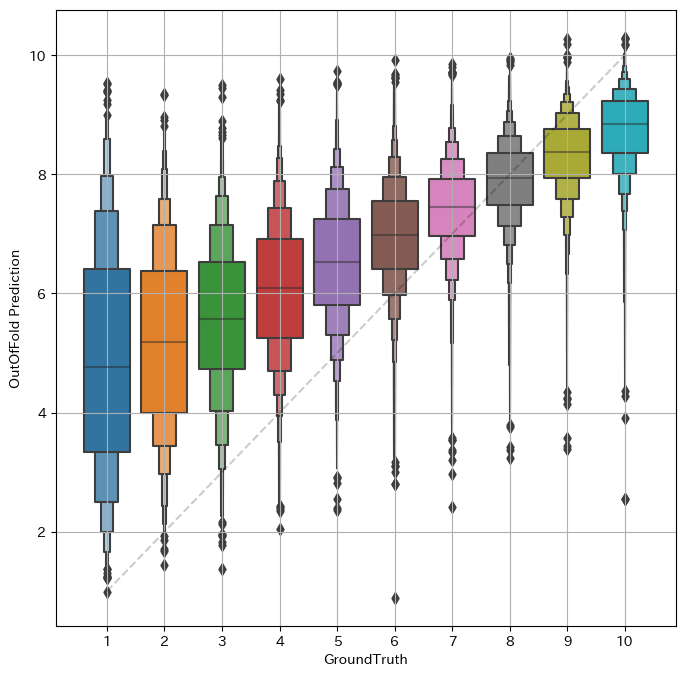

In [92]:
def pred_per_rate(train: pl.DataFrame, oof: np.array) -> None:

    fig, ax = plt.subplots(figsize=(8, 8))


    sns.boxenplot(data=pd.DataFrame({ "GroundTruth": np.array(train.get_column("score")), "OutOfFold Prediction": oof }), 
                x="GroundTruth", y="OutOfFold Prediction", ax=ax)

    ax.grid()
    ax.plot([0, 9], [1, 10], "--", c="black", alpha=.2)

pred_per_rate(train, seen_oof)

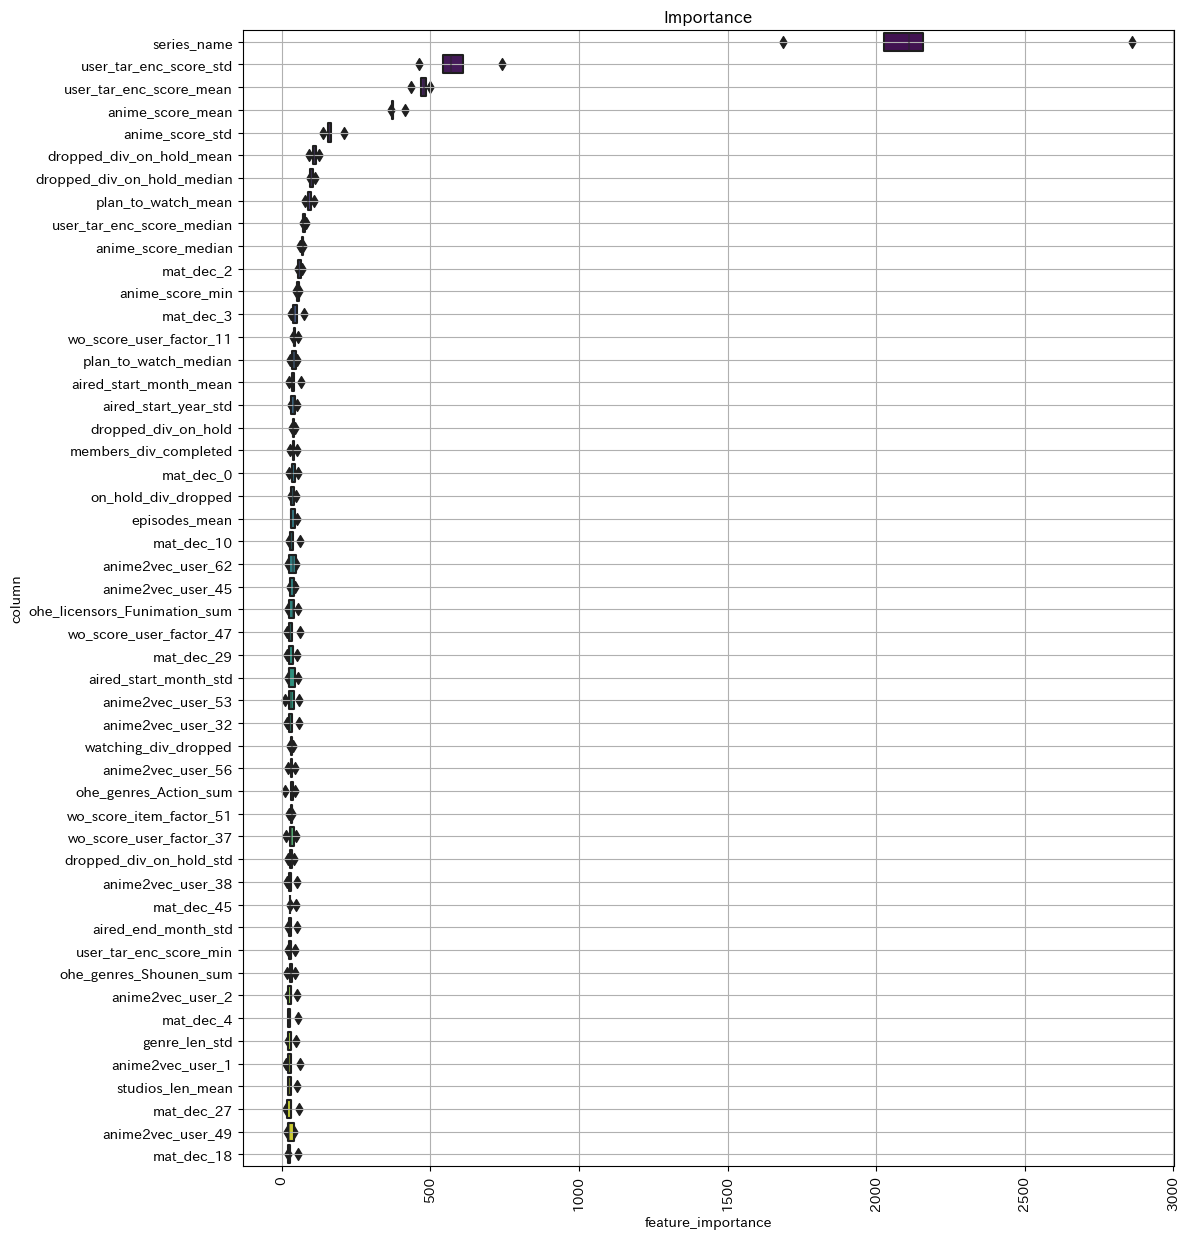

In [93]:
def visualize_importance(models: list, use_col: list) -> None:
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importance()
        _df["column"] = use_col
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x="feature_importance", 
                  y="column", 
                  order=order, 
                  ax=ax, 
                  palette="viridis", 
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(seen_models, seen_use_col)

In [94]:
print(len(seen_use_col))
print(len(unseen_use_col))

645
462


In [95]:
unseen_models, unseen_oof = lgbm(train=train, use_col=unseen_use_col, params=params, fold_col="fold_unseen")

Start fold 0
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.21862	valid_0's rmse: 1.34471
Early stopping, best iteration is:
[81]	training's rmse: 1.24108	valid_0's rmse: 1.34351
fold 0 RMSE: 1.343511223172459
Start fold 1
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Wa

In [96]:
unseen_oof_score = root_mean_squared_error(y_true=train.get_column("score"), y_pred=unseen_oof)
wandb.log({f"unseen_oof_rmse": unseen_oof_score})

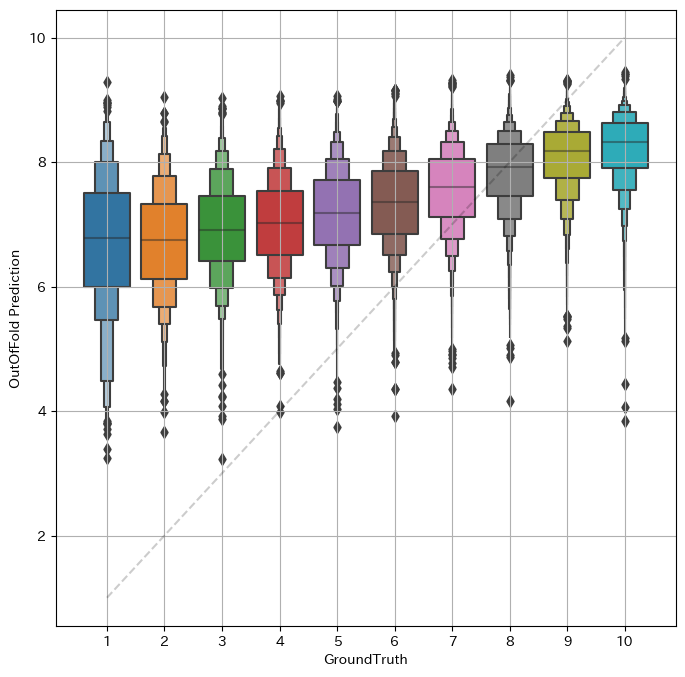

In [97]:
pred_per_rate(train, unseen_oof)

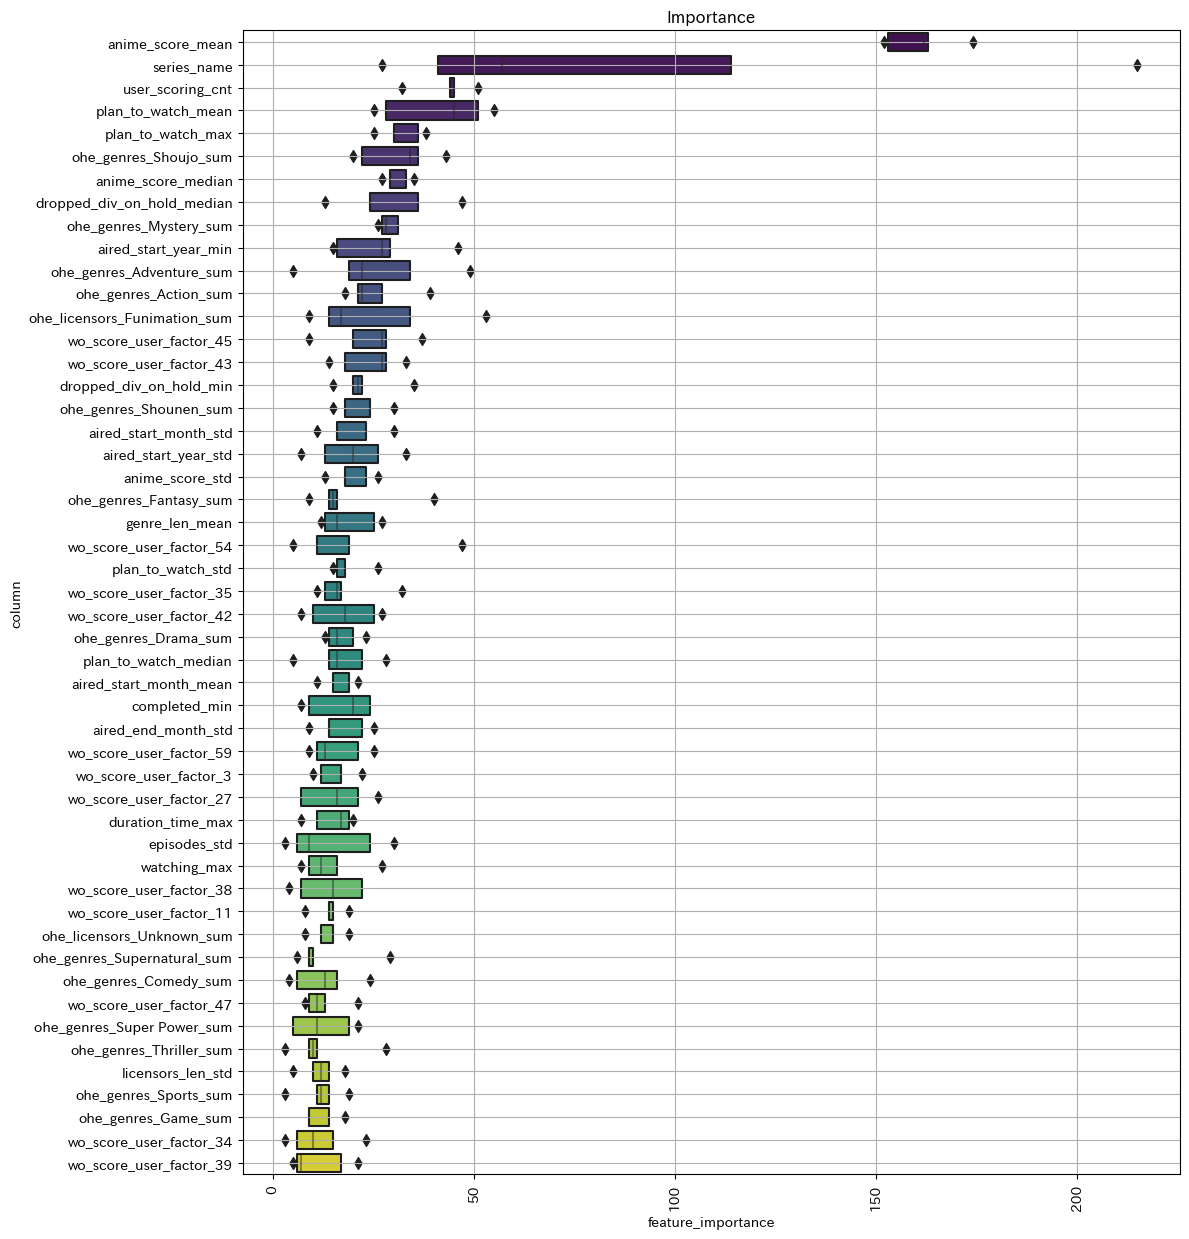

In [98]:
fig, ax = visualize_importance(unseen_models, unseen_use_col)

In [99]:
print(f"seen_oof_score: {seen_oof_score}")
print(f"unseen_oof_score: {unseen_oof_score}")

seen_oof_score: 1.1559718624985122
unseen_oof_score: 1.381156674090764


In [100]:
import math

c_seen = 0.7726469288555016
c_unseen = 0.22735307114449846


def calc_seen_unseen_score(seen, unseen):
    return math.sqrt(c_seen * seen**2 + c_unseen * unseen**2)

oof_score = calc_seen_unseen_score(seen_oof_score, unseen_oof_score)
print(f"oof_score: {oof_score}")
wandb.log({f"seen_unseen_score": oof_score})

oof_score: 1.2108521555900509


# Predict

In [101]:
seen_pred = np.array([model.predict(test.select(seen_use_col).to_pandas()) for model in seen_models])
seen_pred = np.mean(seen_pred, axis=0)

unseen_pred = np.array([model.predict(test.select(unseen_use_col).to_pandas()) for model in unseen_models])
unseen_pred = np.mean(unseen_pred, axis=0)

In [102]:
# train_user_id_setに含まれる行についてはseen_pred, 含まれない行についてはunseen_predの推論結果を用いる

# trainに含まれるuser_idを取得
train_user_id_set = set(list(train.get_column("user_id").unique()))

# TODO: コンペ後、yukiさん、ヨハンさんにレビューをもらう
# 
test = test.with_columns(
    pl.Series(seen_pred).alias("seen_pred")
).with_columns(
    pl.Series(unseen_pred).alias("unseen_pred")
)

test = test.with_columns(
    pl.when(pl.col("user_id").cast(pl.Utf8).is_in(train_user_id_set))
    .then(pl.col("seen_pred"))
    .otherwise(pl.col("unseen_pred"))
    .alias("pred")
)

pred = np.array(test.get_column("pred"))

In [103]:
def diff_test_oof(pred: np.array, oof: np.array):
    fig, ax = plt.subplots(figsize=(8, 6))

    vmax = .02
    bins = np.linspace(0, 10, 100)
    ax.hist(pred, bins=bins, density=True, alpha=.5, label="Test")
    ax.hist(oof, bins=bins, density=True, alpha=.5, label="OutOfFold")
    ax.grid()
    ax.legend()
    ax.set_title("テストとoofの予測傾向差分")

    fig.tight_layout()

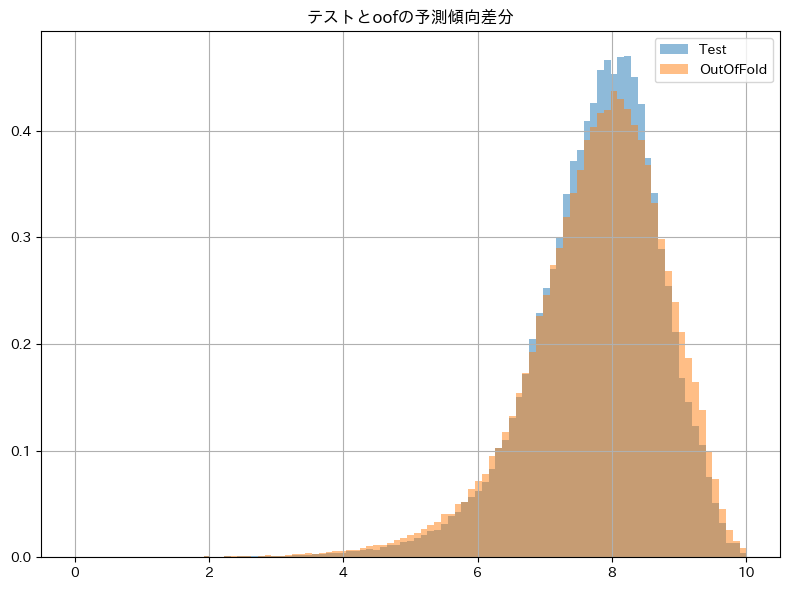

In [104]:
diff_test_oof(pred, seen_oof)

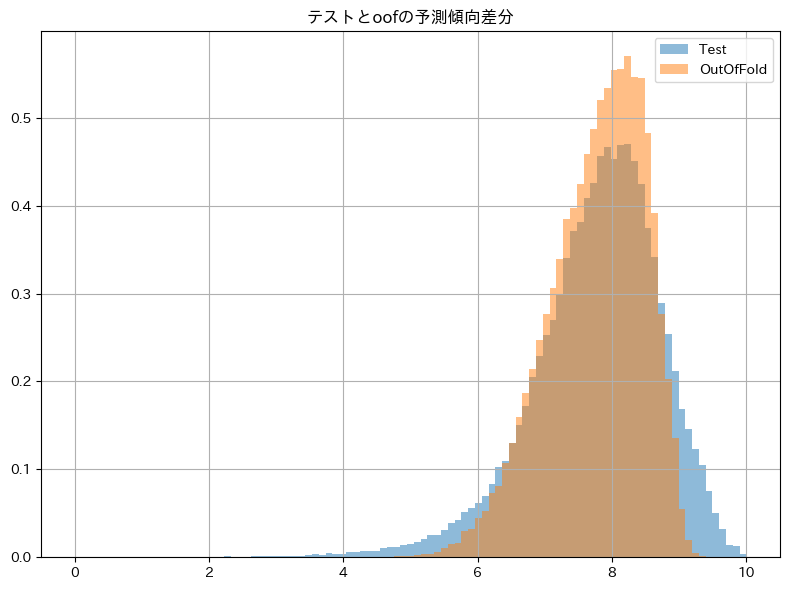

In [105]:
diff_test_oof(pred, unseen_oof)

In [106]:
pl.DataFrame({
    "score": pred
}).write_csv(f"../sub/{Config.exp_name}.csv")

# Error分析

In [107]:
train.with_columns(
    pl.Series(seen_oof).alias("seen_oof"),
    pl.Series(unseen_oof).alias("unseen_oof")
).with_columns(
    (pl.col("seen_oof") - pl.col("score")).abs().alias("seen_oof_diff"),
    (pl.col("unseen_oof") - pl.col("score")).abs().alias("unseen_oof_diff"),
).sort("seen_oof_diff", descending=True).head(1000).write_csv(f"../error_analysis/{Config.exp_name}_error.csv")

In [108]:
wandb.finish()

fold_seen fold0_rmse,▁
fold_seen fold1_rmse,▁
fold_seen fold2_rmse,▁
fold_seen fold3_rmse,▁
fold_seen fold4_rmse,▁
fold_unseen fold0_rmse,▁
fold_unseen fold1_rmse,▁
fold_unseen fold2_rmse,▁
fold_unseen fold3_rmse,▁
fold_unseen fold4_rmse,▁
seen_oof_rmse,▁
